In [1]:
%load_ext autoreload
%autoreload 2

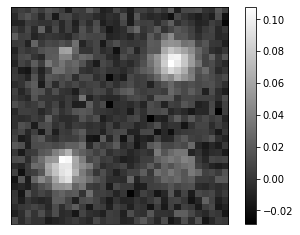

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def gkern(kernlen=21, nsig=3):
    import numpy
    import scipy.stats as st
    
    """Returns a 2D Gaussian kernel array."""
    
    interval = (2*nsig+1.)/(kernlen)
    x = numpy.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = numpy.diff(st.norm.cdf(x))
    kernel_raw = numpy.sqrt(numpy.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

## Simulate Data
np.random.seed(1)

N = 512 # number of subjects in a group
labels = np.zeros((N*2,))
labels[N:] = 1

# 2 confounding effects between 2 groups
cf = np.zeros((N*2,))
cf[:N] = np.random.uniform(1,4,size=N)
cf[N:] = np.random.uniform(3,6,size=N)

# 2 major effects between 2 groups
mf = np.zeros((N*2,))
mf[:N] = np.random.uniform(1,4,size=N)
mf[N:] = np.random.uniform(3,6,size=N)

# simulate images
x = np.zeros((N*2,32,32,1))
y = np.zeros((N*2,))
y[N:] = 1
for i in range(N*2):
    x[i,:16,:16,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i,16:,:16,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,:16,16:,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,16:,16:,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i] = x[i] + np.random.normal(0,0.01,size=(32,32,1))

plt.imshow(x[1,:,:,0],cmap='gray')
plt.colorbar()
#plt.title("a synthetic training image");
plt.xticks(np.arange(0), ())
plt.yticks(np.arange(0), ())
plt.savefig('synthetic_sample.jpg', format='jpg', dpi=300)

In [438]:
from datasets import toy_data
from nma_gan import get_optimizer, discriminator2, discriminator3
from nma_gan import classifier, discriminator_loss, generator_loss, run_a_gan
from torch import nn
from torch.utils.data import DataLoader
# reset_seed(0)
device="cpu"

D2 = discriminator2().to(device)
D3 = discriminator3().to(device)

G = classifier().to(device)

data_train = toy_data.ToyData()
loader_train = DataLoader(data_train, batch_size=128,
                          shuffle=True, drop_last=True, num_workers=2)

D_solver = get_optimizer(nn.ModuleList([D2, D3]))
G_solver = get_optimizer(G)

G, D2, D3 = run_a_gan(loader_train, D2, D3, G, D_solver, G_solver, discriminator_loss, 
                      device, show_every=1, num_epochs=8, l=10)

Iter: 0, D: 2.131, G:0.7229
loss:  0.6961829662322998

Iter: 1, D: 2.116, G:0.7012
loss:  0.6926053166389465

Iter: 2, D: 2.101, G:0.6969
loss:  0.6927217245101929

Iter: 3, D: 2.091, G:0.6914
loss:  0.6906301975250244

Iter: 4, D: 2.084, G:0.6927
loss:  0.6922838091850281

Iter: 5, D: 2.085, G:0.6902
loss:  0.689961314201355

Iter: 6, D: 2.087, G:0.6811
loss:  0.6810099482536316

Iter: 7, D: 2.081, G:0.6803
loss:  0.6802210211753845

Iter: 8, D: 2.093, G:0.6714
loss:  0.6712588667869568

Iter: 9, D: 2.104, G:0.6518
loss:  0.6516333222389221

Iter: 10, D: 2.127, G:0.6146
loss:  0.6143323183059692

Iter: 11, D: 2.15, G:0.5775
loss:  0.5769851803779602

Iter: 12, D: 2.208, G:0.4948
loss:  0.4943557679653168

Iter: 13, D: 2.272, G:0.4307
loss:  0.42969971895217896

Iter: 14, D: 2.359, G:0.3432
loss:  0.33999261260032654

Iter: 15, D: 2.379, G:0.3372
loss:  0.33382582664489746

Iter: 16, D: 2.437, G:0.288
loss:  0.28300023078918457

Iter: 17, D: 2.476, G:0.2536
loss:  0.24917498230934143



In [439]:
y_preds = G(data_train.x.view(-1, 1, 32, 32)).squeeze()
y_preds = (torch.sign(y_preds) + 1) / 2
train_acc = torch.sum(y_preds == data_train.y)
print((train_acc/len(data_train)).item())

0.6962890625


In [418]:
print(data_train.mf[2], data_train.cf[2])

tensor(1.6351) tensor(1.2654)


In [419]:
sample = torch.clone(data_train.x[2, :, :, 0])

In [420]:
G(sample.view(1, 1, 32, 32)).item()

-1.5517332553863525

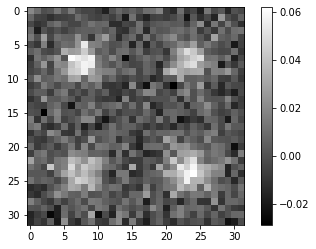

In [421]:
import matplotlib.pyplot as plt
plt.imshow(sample,cmap='gray')
plt.colorbar()

In [422]:
sample[16:, :16] = torch.from_numpy(gkern(kernlen=16, nsig=5)) * 6 + torch.normal(0, 0.01, size=(16, 16))
sample[:16, 16:] = torch.from_numpy(gkern(kernlen=16, nsig=5)) * 6 + torch.normal(0, 0.01, size=(16, 16))

In [423]:
G(sample.view(1, 1, 32, 32)).item()

-1.7824057340621948

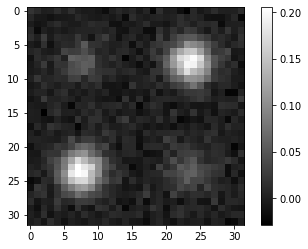

In [424]:
import matplotlib.pyplot as plt
plt.imshow(sample,cmap='gray')
plt.colorbar()

In [373]:
sample[:16, :16] = torch.from_numpy(gkern(kernlen=16, nsig=5)) * 6 + torch.normal(0, 0.01, size=(16, 16))
sample[16:, 16:] = torch.from_numpy(gkern(kernlen=16, nsig=5)) * 6 + torch.normal(0, 0.01, size=(16, 16))

In [374]:
G(sample.view(1, 1, 32, 32)).item()

5.268155574798584

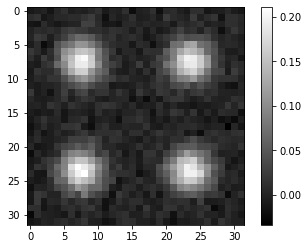

In [375]:
import matplotlib.pyplot as plt
plt.imshow(sample,cmap='gray')
plt.colorbar()

In [378]:
good_classifier = G

## Generate complete data


In [393]:
import nma_gan
from nma_gan import get_optimizer, discriminator1, encoder, discriminator2, discriminator3
from nma_gan import generator, discriminator_loss, generator_loss, run_real_gan
from torch import nn
from torch.utils.data import DataLoader
# reset_seed(0)
device="cpu"

ENC = encoder(classifier=good_classifier)

D1 = discriminator1().to(device)
D2 = discriminator2().to(device)
D3 = discriminator3().to(device)

G = generator().to(device)

data_train = nma_gan.ToyData()
loader_train = DataLoader(data_train, batch_size=128,
                          shuffle=True, drop_last=True, num_workers=2)

D_solver = get_optimizer(nn.ModuleList([D1, D2, D3]))
G_solver = get_optimizer(G)

G, ENC, D1, D2, D3 = run_real_gan(loader_train, D1, D2, D3, G, ENC, D_solver, G_solver, discriminator_loss, generator_loss,
                      device, 'fc_gan_results.jpg', show_every=1, num_epochs=10, l=10)

Iter: 0, D: 3.681, G:0.5333
loss:  0.757709801197052

Iter: 1, D: 2.848, G:0.02391
loss:  0.8278362154960632

Iter: 2, D: 2.808, G:0.006182
loss:  0.7643380165100098

Iter: 3, D: 2.789, G:0.002691
loss:  0.7256178855895996

Iter: 4, D: 2.781, G:0.001647
loss:  0.8050156831741333

Iter: 5, D: 2.765, G:0.001033
loss:  0.8004238605499268

Iter: 6, D: 2.754, G:0.0009727
loss:  0.8906666040420532

Iter: 7, D: 2.715, G:0.0007595
loss:  0.7969586849212646

Iter: 8, D: 2.697, G:0.000727
loss:  0.8346328139305115

Iter: 9, D: 2.683, G:0.0004096
loss:  0.7705445885658264

Iter: 10, D: 2.672, G:0.0008406
loss:  0.786487340927124

Iter: 11, D: 2.742, G:0.0003676
loss:  0.7209510207176208

Iter: 12, D: 2.676, G:0.0004414
loss:  0.7887488007545471

Iter: 13, D: 2.612, G:0.001577
loss:  0.827727735042572

Iter: 14, D: 2.607, G:0.001227
loss:  0.80400151014328

Iter: 15, D: 2.591, G:0.0002047
loss:  0.7279852032661438

Iter: 16, D: 2.781, G:0.0004377
loss:  0.6926287412643433

Iter: 17, D: 2.936, G:0.

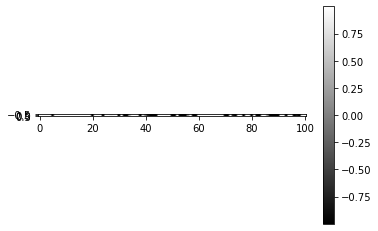

In [398]:
from nma_gan import sample_noise
g_fake_seed = sample_noise(1, 96, dtype=sample.dtype, device=sample.device)
fake_features_and_preds = G(g_fake_seed)
import matplotlib.pyplot as plt
plt.imshow(fake_features_and_preds.detach(),cmap='gray')
plt.colorbar()

Iter: 0, loss: 91111.2265625


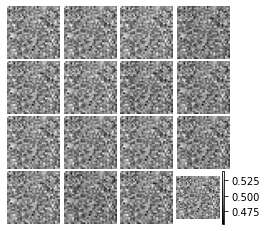


Iter: 8, loss: 8069.080078125


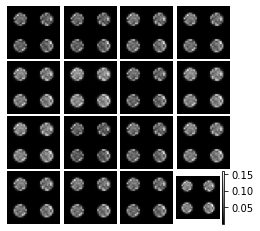


Iter: 16, loss: 7335.8515625


<Figure size 432x288 with 0 Axes>

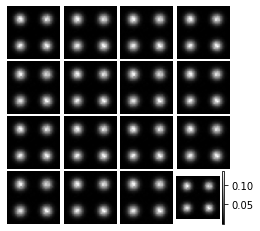


Iter: 24, loss: 7114.06689453125


<Figure size 432x288 with 0 Axes>

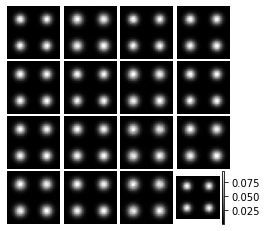


Iter: 32, loss: 7188.59326171875


<Figure size 432x288 with 0 Axes>

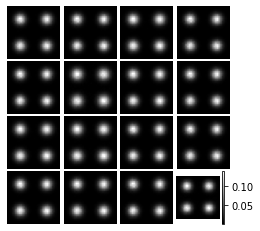


Iter: 40, loss: 7457.419921875


<Figure size 432x288 with 0 Axes>

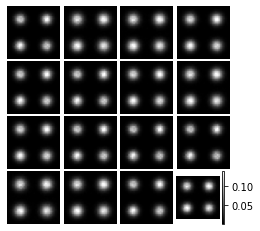


Iter: 48, loss: 7386.0888671875


<Figure size 432x288 with 0 Axes>

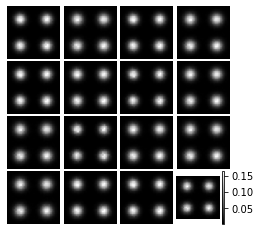


Iter: 56, loss: 7268.8232421875


<Figure size 432x288 with 0 Axes>

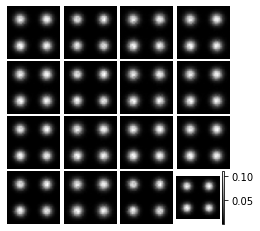


Iter: 64, loss: 7149.3564453125


<Figure size 432x288 with 0 Axes>

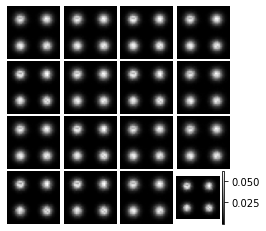


Iter: 72, loss: 7423.83447265625


<Figure size 432x288 with 0 Axes>

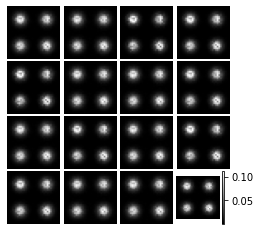


Iter: 80, loss: 7308.9501953125


<Figure size 432x288 with 0 Axes>

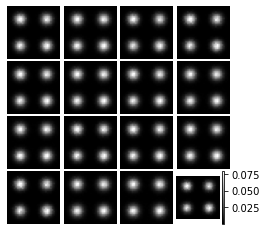


Iter: 88, loss: 7269.71044921875


<Figure size 432x288 with 0 Axes>

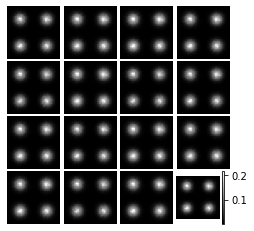


Iter: 96, loss: 7257.95849609375


<Figure size 432x288 with 0 Axes>

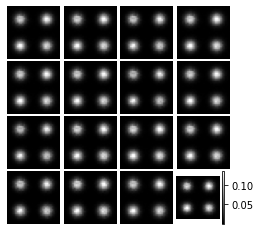


Iter: 104, loss: 6968.1376953125


<Figure size 432x288 with 0 Axes>

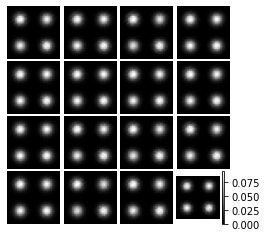


Iter: 112, loss: 7507.82763671875


<Figure size 432x288 with 0 Axes>

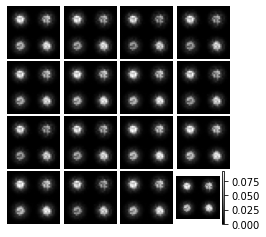


Iter: 120, loss: 7272.05859375


<Figure size 432x288 with 0 Axes>

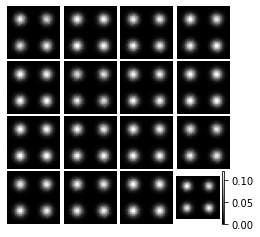


Iter: 128, loss: 7215.51318359375


<Figure size 432x288 with 0 Axes>

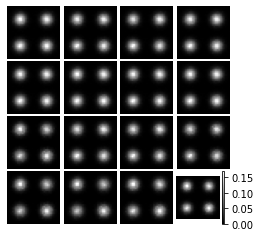


Iter: 136, loss: 7437.47998046875


<Figure size 432x288 with 0 Axes>

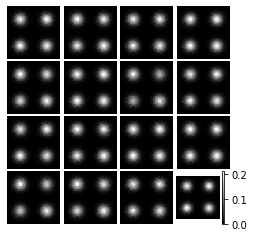


Iter: 144, loss: 7546.1943359375


<Figure size 432x288 with 0 Axes>

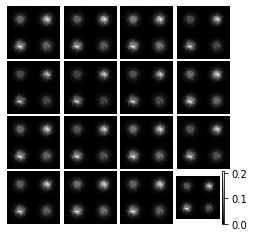


Iter: 152, loss: 7227.3896484375


<Figure size 432x288 with 0 Axes>

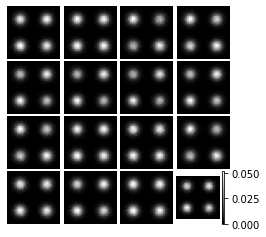


Iter: 160, loss: 7426.201171875


<Figure size 432x288 with 0 Axes>

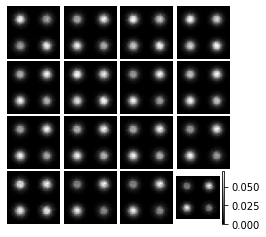


Iter: 168, loss: 7066.26220703125


<Figure size 432x288 with 0 Axes>

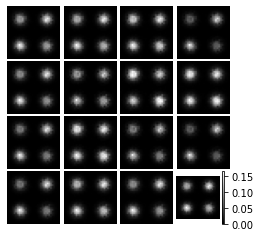


Iter: 176, loss: 6966.76513671875


<Figure size 432x288 with 0 Axes>

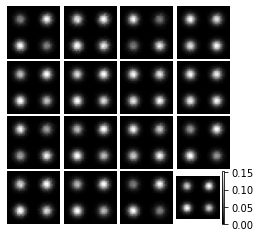


Iter: 184, loss: 7459.52685546875


<Figure size 432x288 with 0 Axes>

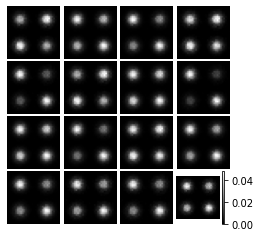


Iter: 192, loss: 7171.45556640625


<Figure size 432x288 with 0 Axes>

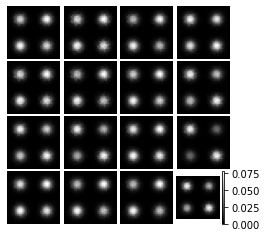


Iter: 200, loss: 7153.69140625


<Figure size 432x288 with 0 Axes>

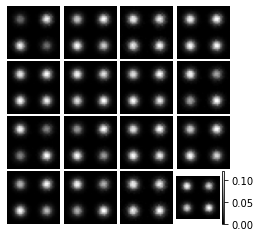


Iter: 208, loss: 7350.0068359375


<Figure size 432x288 with 0 Axes>

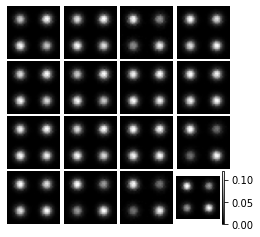


Iter: 216, loss: 7138.27685546875


<Figure size 432x288 with 0 Axes>

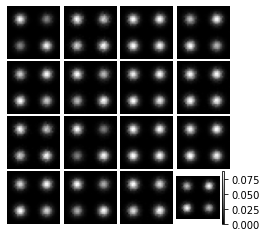


Iter: 224, loss: 7135.333984375


<Figure size 432x288 with 0 Axes>

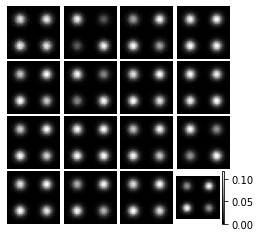


Iter: 232, loss: 7611.91015625


<Figure size 432x288 with 0 Axes>

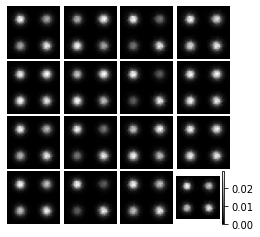


Iter: 240, loss: 7245.3544921875


<Figure size 432x288 with 0 Axes>

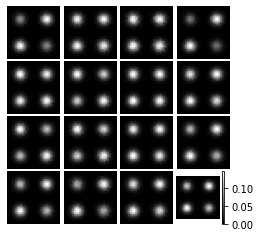

<Figure size 432x288 with 0 Axes>

In [403]:
from nma_gan import decoder, train_decoder, get_optimizer
DEC = decoder()
optim = get_optimizer(DEC, lr=1e-2)
DEC = train_decoder(loader_train, ENC, DEC, optim, device, num_epochs=30)

## Regularized Classifier

In [35]:
from datasets import toy_data
from nma_gan import get_optimizer
from nma_gan import classifier, discriminator_loss, generator_loss, run_regularized_classifier
from torch import nn
from torch.utils.data import DataLoader
# reset_seed(0)
device="cpu"

G = classifier().to(device)

data_train = toy_data.ToyData()
loader_train = DataLoader(data_train, batch_size=128,
                          shuffle=True, drop_last=True, num_workers=2)

G_solver = get_optimizer(G)

G = run_regularized_classifier(loader_train, G, G_solver,
                      device, show_every=1, num_epochs=8, l=10000)

tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
tensor(17)
tensor(31)
Iter: 0, G:4.8e+05
loss:  0.6868953704833984

tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
tensor(18)
tensor(20)
Iter: 1, G:3.8e+05
loss:  0.694062352180481

tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
tensor(34)
tensor(36)
Iter: 2, G:7e+05
loss:  0.6881343126296997

tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(18)
tensor(10)
tensor(

tensor(34)
tensor(4)
tensor(34)
tensor(4)
tensor(34)
tensor(4)
tensor(35)
tensor(4)
tensor(34)
Iter: 33, G:3.8e+05
loss:  0.23346857726573944

tensor(4)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
tensor(2)
tensor(31)
Iter: 34, G:3.3e+05
loss:  0.2059633731842041

tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
tensor(2)
tensor(24)
Iter: 35, G:2.6e+05
loss:  0.18446354568004608

tensor(1)
tensor(15)
tensor(1)
tensor(16)
tensor(1)
tensor(17)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
tensor(1)
tensor(15)
Iter: 36, G:1.6e+05
loss:  0.17184968292713165

tensor(8)
tensor(16)
tensor(7)
tensor(18)
tensor(8)
tensor(18)
tensor(8)
tensor(17)


In [36]:
y_preds = G(data_train.x.view(-1, 1, 32, 32)).squeeze()
y_preds = (torch.sign(y_preds) + 1) / 2
train_acc = torch.sum(y_preds == data_train.y)
print((train_acc/len(data_train)).item())

0.9443359375


Text(0, 0.5, 'sigma_A')

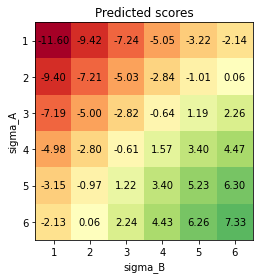

In [34]:
from datasets import toy_data
data = toy_data.full_toy_data(device=device)
# data += torch.normal(0, 0.01, size=(6, 6, 32, 32), device=device)
preds = G(data.view(-1, 1, 32, 32)).reshape(6, 6)
scale = max(torch.abs(torch.min(preds)), torch.abs(torch.max(preds)))
fig, ax = plt.subplots()
im = ax.imshow(preds.detach().cpu().numpy(), cmap="RdYlGn", vmin=-scale, vmax=scale)

ax.set_xticks(np.arange(preds.shape[1]), labels=np.arange(preds.shape[1]) + 1)
ax.set_yticks(np.arange(preds.shape[0]), labels=np.arange(preds.shape[0]) + 1)
for i in range(preds.shape[0]):
    for j in range(preds.shape[1]):
        text = ax.text(j, i, f"{preds[i, j]:0.2f}",
                       ha="center", va="center", color="k")
ax.set_title("Predicted scores")
ax.set_xlabel('sigma_B')
ax.set_ylabel('sigma_A')

## Preliminary face dataset experiments

In [22]:
import torch
import nma_gan
from nma_gan import get_optimizer, discriminator1, encoder, discriminator2, discriminator3
from nma_gan import generator, discriminator_loss, generator_loss, run_real_gan
from torch import nn
from torch.utils.data import DataLoader
# reset_seed(0)
device="cpu"

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()
model.classifier = nn.Sequential(*list(model.classifier.children())[:-3])
ENC = model

D1 = discriminator1(latent_dim=4096).to(device)
D2 = discriminator2().to(device)
D3 = discriminator3().to(device)

G = generator(latent_dim=4096).to(device)

data_train = nma_gan.FaceData()
loader_train = DataLoader(data_train, batch_size=128,
                          shuffle=True, drop_last=True, num_workers=2)

D_solver = get_optimizer(nn.ModuleList([D1, D2, D3]))
G_solver = get_optimizer(G)

Using cache found in C:\Users\jense/.cache\torch\hub\pytorch_vision_v0.10.0


In [23]:
G, ENC, D1, D2, D3 = run_real_gan(loader_train, D1, D2, D3, G, ENC, D_solver, G_solver, discriminator_loss, generator_loss,
                      device, 'fc_gan_results.jpg', show_every=1, num_epochs=10, l=10)

tensor([[2.0000, 0.2053, 1.0000],
        [6.0000, 0.9621, 0.0000],
        [5.0000, 0.9845, 0.0000],
        [5.0000, 0.5730, 1.0000],
        [6.0000, 0.5058, 0.0000],
        [6.0000, 0.2630, 1.0000],
        [2.0000, 0.2560, 0.0000],
        [5.0000, 0.3225, 1.0000],
        [2.0000, 0.0200, 0.0000],
        [3.0000, 0.5420, 1.0000],
        [2.0000, 0.0320, 0.0000],
        [5.0000, 0.0678, 1.0000],
        [6.0000, 0.9848, 0.0000],
        [2.0000, 0.5566, 0.0000],
        [3.0000, 0.5976, 0.0000],
        [6.0000, 0.0117, 0.0000],
        [2.0000, 0.6806, 1.0000],
        [5.0000, 0.7071, 1.0000],
        [3.0000, 0.0215, 1.0000],
        [2.0000, 0.5968, 0.0000],
        [5.0000, 0.1061, 1.0000],
        [4.0000, 0.7193, 1.0000],
        [4.0000, 0.9661, 0.0000],
        [6.0000, 0.2069, 0.0000],
        [4.0000, 0.6837, 1.0000],
        [1.0000, 0.3634, 0.0000],
        [5.0000, 0.4396, 0.0000],
        [6.0000, 0.9290, 0.0000],
        [2.0000, 0.1438, 1.0000],
        [2.000

KeyboardInterrupt: 

In [21]:
nma_gan.FaceData()

torch.float32
torch.bool
torch.float64
